### Neurophysiology and Biophysics - Practical course WS 2024/25
__Cornelia Kopp-Scheinpflug & Kay Thurley__

# Miniproject: Gap junctions and network synchorization

In this notebook we simulate a small network of electrically coupled Drosophila motoneurons. The network shows different regimes of synchrony depending on the coupling strength of the GAP junctions, which is supposed to underly the insect's flight. The model was used in Hürkey et al. (2023) and adapted by Kay Thurley (2024).


_Requirements:_ You will need Python 3 and the packages Numpy, Matplotlib and BRIAN2.


We start by importing the relevant packages.

In [1]:
import numpy as np
from brian2 import *
import sys, os
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import json

from utils.brianutils import units
from utils.random_initial_conditions import *
from utils.sim import *
from utils.convert_ggap_ccs import *
from utils.spiketime_analysis_helper import *

saving/loading sims from:  sim_results/


Then we define load some parameters and define the neuron.

In [2]:
md_SNL = json.load(open("cfg/Berger_SNL.json"))
md_SNIC = json.load(open("cfg/Berger_SNIC.json"))
ggap_hom = np.load('cfg/ggap_hom.npy')*nS
ggap_het = np.load('cfg/ggap_het.npy')*nS

In [ ]:
# noise free simulations
# ## case1: weak SNL
# used for figure 3B
N = 5
g_gap = ggap_hom
# g_gap = .15*nS
dur = 10*second
solver = 'heun'#'rk4'
dt = 100*us
# noise 5e-8 is too high 
# noise 1e-8 it low enough to get 2 states
# noise 2e-8 gives 10 states!

# try noise levels between 
noise_stdev = 3e-8
fname='SNL_weakcoupling_nonoise'

φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
initial_values = pick_initial_phase_SNL(φs_chosen)
StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
                     dur=dur, σnoise=noise_stdev, solver=solver, dt=dt)

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value array([[ 0.        , 86.58631126, 38.26934378, 38.26934378, 27.1874998 ],
       [86.58631126,  0.        , 38.26934378, 38.26934378, 27.1874998 ],
       [38.26934378, 38.26934378,  0.        , 86.58631126, 27.1874998 ],
       [38.26934378, 38.26934378, 86.58631126,  0.        , 27.1874998 ],
    

Starting simulation at t=0. s for a duration of 10. s
4.3853 s (43%) simulated in 10s, estimated 13s remaining.
8.9054 s (89%) simulated in 20s, estimated 2s remaining.
10. s (100%) simulated in 22s


Text(0.97, 0.184, '[mV]')

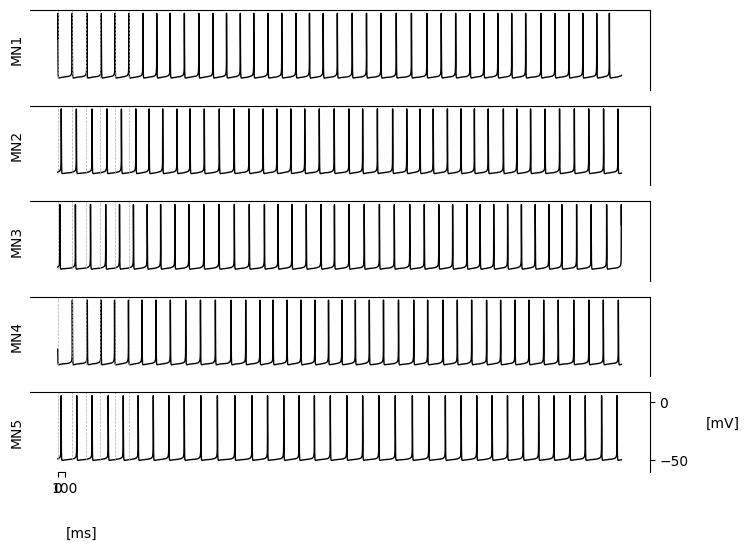

In [4]:
fig, ax = plt.subplots(5, 1, figsize=(8, 6))

ts=StM1.t_
per=np.median(np.diff(SpM1.t_[SpM1.i==0]))*second
t_unit=ms
N=5

tstart = SpM1.t_[SpM1.i==0][SpM1.t_[SpM1.i==0]>2].min()
m=(ts>tstart) & (ts<tstart+10)
for i in range(N):
    ax[i].plot(StM1.t[m]/ms-tstart*1000, StM1.v[i][m]/mV, c='k',lw=1)
    ax[i].spines['left'].set_visible(False)
    ax[i].set_ylabel('MN{}'.format(i+1))
    ax[i].set_yticks([])
    ax[i].set_ylim(-60,)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_xticks([])
    # shift = 2000
    # ax[i].set_xlim(0 + shift,300 + shift)

    for k in range(0,6):
        ax[i].plot([k*per/t_unit,k*per/t_unit],[-50,10],'--',lw=0.5,c='darkgrey')


ax[-1].set_xticks([0,100])
ax[-1].spines['bottom'].set_bounds(0,100)
ax[-1].spines['bottom'].set_visible(True)
fig.text(0.17,0.0,'[ms]')

ax[-1].spines['right'].set_visible(True)
ax[-1].yaxis.tick_right()
ax[-1].set_yticks([-50,0])
fig.text(0.97,0.184,'[mV]')

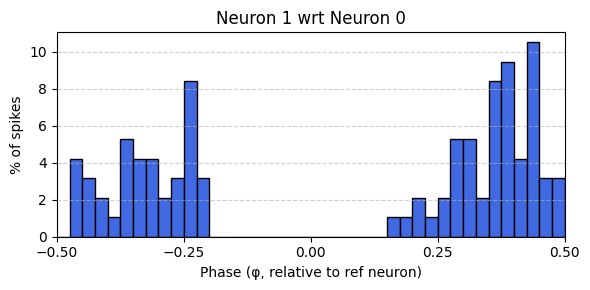

In [11]:
def phase_histogram(SpM, idx_ref, idx_target, bins=30, ax=None):
    """
    Compute and plot phase histogram of target neuron's spikes 
    relative to reference neuron's cycle.
    
    Parameters
    ----------
    SpM : SpikeMonitor
        Brian2 SpikeMonitor object with attributes `.t` (times) and `.i` (indices).
    idx_ref : int
        Index of reference neuron (e.g., MN4).
    idx_target : int
        Index of target neuron (e.g., MN5).
    bins : int
        Number of histogram bins.
    ax : matplotlib axis or None
        If provided, plot on this axis. Otherwise, create a new one.
        
    Returns
    -------
    phases : np.ndarray
        Array of phase values (wrapped to [-0.5, 0.5)).
    """

    # Extract spikes for each neuron
    t_ref = np.array(SpM.t[SpM.i == idx_ref])
    t_tar = np.array(SpM.t[SpM.i == idx_target])
    if len(t_ref) < 2 or len(t_tar) == 0:
        raise ValueError("Not enough spikes to compute phase relationship.")

    phases = []
    for i in range(len(t_ref) - 1):
        tA, tA_next = t_ref[i], t_ref[i + 1]
        cycle_duration = tA_next - tA
        mask = (t_tar >= tA - 0.5 * cycle_duration) & (t_tar < tA_next + 0.5 * cycle_duration)
        relevant_B = t_tar[mask]

        for tB in relevant_B:
            phi = (tB - tA) / cycle_duration
            # Wrap to [-0.5, 0.5)
            phi = ((phi + 0.5) % 1.0) - 0.5
            phases.append(phi)

    phases = np.array(phases)

    # --- Plotting ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 3))

    counts, edges = np.histogram(phases, bins=bins, range=(-0.5, 0.5))
    counts = counts / counts.sum() * 100  # convert to percentage

    ax.bar((edges[:-1] + edges[1:]) / 2, counts, width=1/bins, color='royalblue', edgecolor='black')
    ax.set_xlabel('Phase (φ, relative to ref neuron)')
    ax.set_ylabel('% of spikes')
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.set_title(f'Neuron {idx_target} wrt Neuron {idx_ref}')

    plt.tight_layout()
    return phases

# Assuming SpM1 is your SpikeMonitor
phases = phase_histogram(SpM1, idx_ref=0, idx_target=1, bins=40)


In [20]:
# Coupling coefficient
from utils.convert_ggap_ccs import *
print(ggap2cc(g_gap))

[[-1.51188730e-15  9.94035397e-03  4.41793510e-03  4.41793510e-03
   3.14263213e-03]
 [ 9.94035397e-03 -1.51188730e-15  4.41793510e-03  4.41793510e-03
   3.14263213e-03]
 [ 4.41793510e-03  4.41793510e-03 -1.51188730e-15  9.94035397e-03
   3.14263213e-03]
 [ 4.41793510e-03  4.41793510e-03  9.94035397e-03 -1.51188730e-15
   3.14263213e-03]
 [ 3.14263213e-03  3.14263213e-03  3.14263213e-03  3.14263213e-03
  -1.51188730e-15]]


0.0638 9.8539
97901


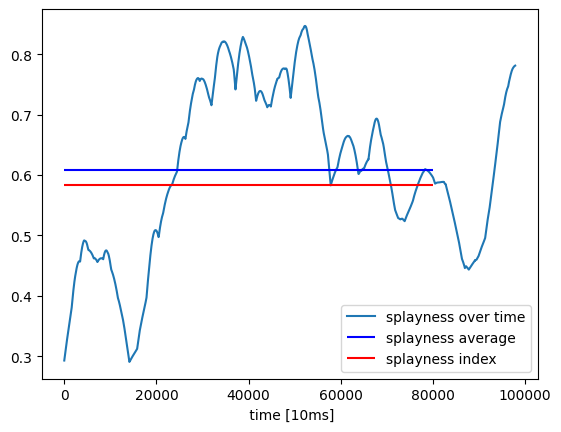

In [21]:
from utils.spiketime_analysis_helper import *
# Splayness index
# Make sure tstart tend and dt have same units 
tmin, tmax = get_tminmax(SpM1)
print(tmin, tmax)
print(len(get_splayness(SpM1, tmin, tmax, 100e-6)[0]))
plt.plot(get_splayness(SpM1, tmin, tmax, 100e-6)[0], label ='splayness over time')
plt.hlines(np.mean(get_splayness(SpM1, tmin, tmax, 100e-6)[0]),0, 80000, color='b', label = 'splayness average')
plt.hlines(get_splayness(SpM1, tmin, tmax, 100e-6)[1],0, 80000, color='r', label = 'splayness index')
plt.xlabel(' time [10ms]')
plt.legend()
plt.show()

In [22]:
from collections import defaultdict

def extract_splay_sequences(spike_ids, spike_times, N=5):
    pattern_times = defaultdict(list)

    # find indices where neuron 0 spikes
    zero_spike_indices = np.where(spike_ids == 0)[0]

    for idx in zero_spike_indices:
        # make sure there are at least N spikes after this 0
        if idx + N <= len(spike_ids):
            pattern = ''.join(str(x) for x in spike_ids[idx:idx + N])
            t = spike_times[idx]  # time of this pattern’s start (neuron 0 spike)
            pattern_times[pattern].append(t)

    return pattern_times

In [23]:
patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

for p, times in patterns.items():
    print(f"Pattern {p} occurred {len(times)} times at times {np.round(times,3)}")


Pattern 04312 occurred 4 times at times [0.016 0.219 1.436 1.667]
Pattern 01432 occurred 13 times at times [0.407 0.584 0.784 7.203 7.426 7.656 7.877 8.105 8.334 8.554 9.246 9.471
 9.701]
Pattern 01243 occurred 5 times at times [0.996 2.757 2.948 4.537 4.729]
Pattern 01204 occurred 1 times at times [1.213]
Pattern 03412 occurred 1 times at times [1.894]
Pattern 01423 occurred 8 times at times [2.114 2.333 2.546 4.344 6.381 6.572 6.777 6.993]
Pattern 01234 occurred 7 times at times [3.136 3.326 3.537 4.943 5.162 5.381 5.594]
Pattern 01230 occurred 2 times at times [3.747 5.794]
Pattern 04123 occurred 4 times at times [3.942 4.15  5.996 6.189]
Pattern 04321 occurred 1 times at times [8.79]
Pattern 04320 occurred 1 times at times [9.011]


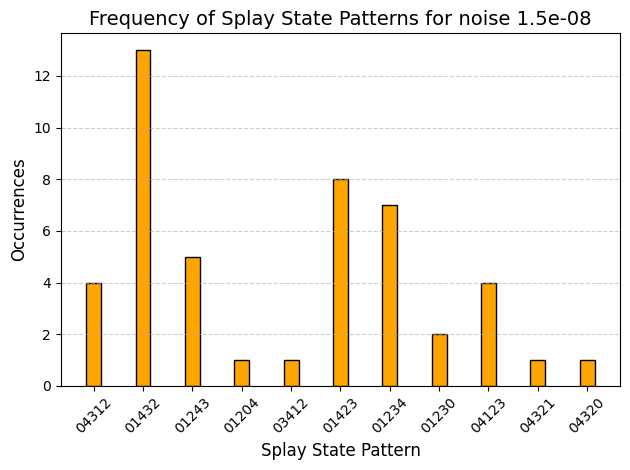

In [24]:
# Assuming you've already run:
# patterns = extract_splay_sequences(SpM1.i, SpM1.t, N=5)

# Extract data for plotting
pattern_names = list(patterns.keys())
occurrences = [len(times) for times in patterns.values()]

# # Sort by most frequent pattern (optional, for clarity)
# sorted_idx = np.argsort(occurrences)[::-1]
# pattern_names = [pattern_names[i] for i in sorted_idx]
# occurrences = [occurrences[i] for i in sorted_idx]

# Plot
plt.figure()
plt.bar(pattern_names, occurrences, color='orange', edgecolor='black', width=0.3)
plt.xlabel('Splay State Pattern', fontsize=12)
plt.ylabel('Occurrences', fontsize=12)
plt.title(f'Frequency of Splay State Patterns for noise {noise_stdev}', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [25]:
SpM1.i

<spikemonitor_1.i: array([0, 4, 3, 1, 2, 0, 4, 3, 1, 2, 0, 1, 4, 3, 2, 0, 1, 4, 3, 2, 0, 1,
       4, 3, 2, 0, 1, 2, 4, 3, 0, 1, 2, 0, 4, 3, 1, 2, 0, 4, 3, 1, 2, 0,
       3, 4, 1, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1,
       2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
       4, 0, 1, 2, 3, 0, 4, 1, 2, 3, 0, 4, 1, 2, 3, 0, 1, 4, 2, 3, 0, 1,
       2, 4, 3, 0, 1, 2, 4, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3,
       4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 4, 1, 2, 3, 0, 4, 1, 2, 3, 0, 1,
       4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 2, 3, 0, 1, 4, 3,
       2, 0, 1, 4, 3, 2, 0, 1, 4, 3, 2, 0, 1, 4, 3, 2, 0, 1, 4, 3, 2, 0,
       1, 4, 3, 2, 0, 1, 4, 3, 2, 1, 0, 4, 3, 2, 1, 0, 4, 3, 2, 0, 1, 4,
       3, 2, 0, 1, 4, 3, 2, 0, 1, 4, 3, 2, 0, 1, 4, 3])>

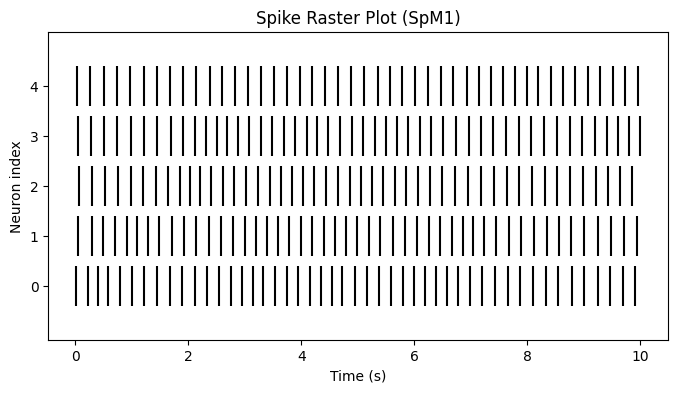

In [26]:
# Extract spike times and indices
spike_times = SpM1.t / second   # convert to float seconds
spike_indices = SpM1.i

# Number of neurons (assuming indices start at 0)
n_neurons = int(max(spike_indices)) + 1

# Collect spikes per neuron
spike_trains = [spike_times[spike_indices == i] for i in range(n_neurons)]

# Plot raster
plt.figure(figsize=(8, 4))
plt.eventplot(spike_trains, colors='black', linelengths=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Neuron index")
plt.title("Spike Raster Plot (SpM1)")
plt.yticks(range(n_neurons))
plt.show()


In [ ]:
# raise

RuntimeError: No active exception to reraise

In [7]:
### Splayness vs coupling coefficient
# cc_array = [0.001, 0.1, 0.2, 0.3]
cc_array = np.arange(0.01, 0.31, 0.02)
spm_array = []
for cc in cc_array:
    g_gap_now = cc2ggap(cc)
    N = 5
    g_gap = g_gap_now
    # g_gap = .15*nS
    dur = 5*second
    solver = 'rk4'
    dt = 100*us

    fname='SNL_weakcoupling_nonoise'

    φs_chosen = np.array([0.9, 0.6, 0.5, 0.7, 0.8])
    initial_values = pick_initial_phase_SNL(φs_chosen)
    StM1, SpM1 = run_sim(N, md_SNL, g_gap, None, initial_values=initial_values,
                        dur=dur, σnoise=None, solver=solver, dt=dt) 
    spm_array.append(get_splayness(SpM1, 1, 4, 100e-6)[1])
    print(f'cc={cc}: {get_splayness(SpM1, 1, 4, 100e-6)[1]}')



Starting simulation at t=0. s for a duration of 5. s
1.9293 s (38%) simulated in 10s, estimated 16s remaining.
3.655 s (73%) simulated in 20s, estimated 7s remaining.
5. s (100%) simulated in 26s
cc=0.01: 0.9987796144317095


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 266.72164948 * psiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0651 s (41%) simulated in 10s, estimated 14s remaining.
4.0248 s (80%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.03: 0.9977238493327377


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0.45389474 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0411 s (40%) simulated in 10s, estimated 14s remaining.
3.9796 s (79%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 25s
cc=0.049999999999999996: 0.9972179479606559


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0.64911828 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.9701 s (39%) simulated in 10s, estimated 15s remaining.
4.0275 s (80%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.06999999999999999: 0.6135469440424068


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0.85292308 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0411 s (40%) simulated in 10s, estimated 14s remaining.
4.1013 s (82%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.08999999999999998: 0.5654749644210726


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 1.06588764 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0463 s (40%) simulated in 10s, estimated 14s remaining.
4.1085 s (82%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.10999999999999997: 0.5735797326286354


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 1.28864368 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0033 s (40%) simulated in 10s, estimated 15s remaining.
4.0743 s (81%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.12999999999999998: 0.5803500716497805


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 1.52188235 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.9935 s (39%) simulated in 10s, estimated 15s remaining.
4.0078 s (80%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.15: 0.5967341919021929


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 1.76636145 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0031 s (40%) simulated in 10s, estimated 15s remaining.
4.0048 s (80%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 25s
cc=0.16999999999999998: 0.6387806237355379


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.02291358 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.028 s (40%) simulated in 10s, estimated 15s remaining.
4.0547 s (81%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.18999999999999997: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.2924557 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0213 s (40%) simulated in 10s, estimated 15s remaining.
4.0658 s (81%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.20999999999999996: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.576 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0436 s (40%) simulated in 10s, estimated 14s remaining.
4.1138 s (82%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.22999999999999998: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 2.87466667 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0535 s (41%) simulated in 10s, estimated 14s remaining.
4.0532 s (81%) simulated in 20s, estimated 5s remaining.
5. s (100%) simulated in 24s
cc=0.24999999999999997: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3.18969863 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0278 s (40%) simulated in 10s, estimated 15s remaining.
4.0924 s (81%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.26999999999999996: 0.0


WARNING    'g_gap' is an internal variable of group 'synapses', but also exists in the run namespace with the value 3.52247887 * nsiemens. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
2.0598 s (41%) simulated in 10s, estimated 14s remaining.
4.1282 s (82%) simulated in 20s, estimated 4s remaining.
5. s (100%) simulated in 24s
cc=0.29: 0.0


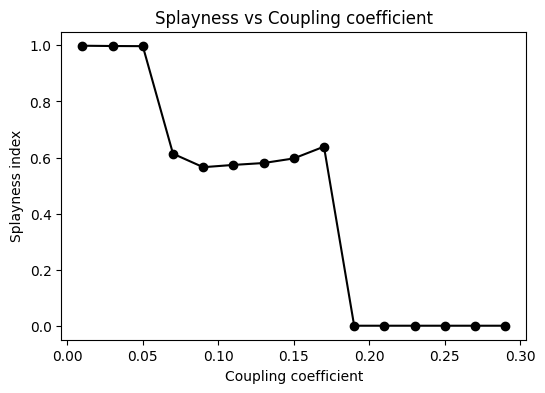

In [8]:
# plot cc vs splayness
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cc_array, spm_array, '-o', c='k')
ax.set_xlabel('Coupling coefficient')
ax.set_ylabel('Splayness index')
ax.set_title('Splayness vs Coupling coefficient')
plt.show()



In [ ]:
tstart 

2.0738

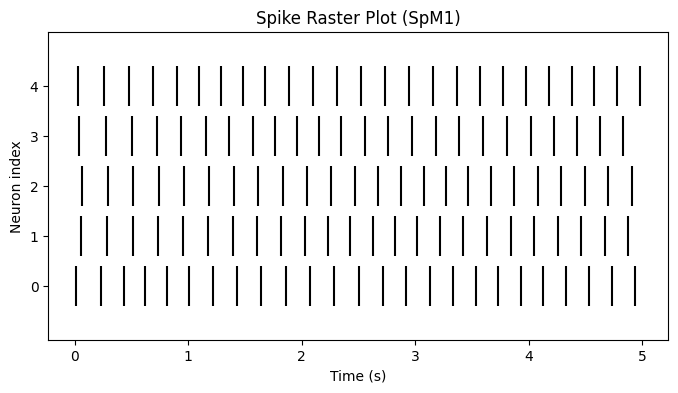

In [ ]:
# find interspike intervals for 4 neurons
N = 5
isi_list = []
for i in range(N):
    spike_times_i = SpM1.t_[SpM1.i == i] / ms  # convert to ms
    isis = np.diff(spike_times_i)  # interspike intervals
    isi_list.append(isis)

print("Interspike Intervals (ms) for each neuron:")
for i, isis in enumerate(isi_list):
    print(f"Neuron {i}: {isis}")
#!/usr/bin/env python3
import numpy as np
from brian2 import *

Interspike Intervals (ms) for each neuron:
Neuron 0: [215.2 202.5 190.7 189.6 198.2 206.4 211.6 214.3 214.9 214.7 214.3 213.1
 211.3 209.  206.4 203.5 200.5 198.2 197.3 198.3 200.2 202.5 204.4 205.5] Hz
Neuron 1: [231.7 226.6 222.4 220.7 218.8 216.8 214.8 212.2 208.1 203.4 198.8 195.4
 195.2 198.  201.8 204.9 206.9 208.  208.2 208.  207.2 206.  204.6] Hz
Neuron 2: [229.2 225.5 222.3 221.2 219.9 218.7 217.7 216.2 213.9 211.6 208.8 205.1
 201.1 197.8 196.6 197.7 200.3 203.1 205.2 206.6 207.3 207.4 206.9] Hz
Neuron 3: [232.  226.5 220.9 217.6 214.  209.3 203.5 197.2 192.9 193.8 198.6 203.4
 206.9 208.9 209.9 210.2 209.8 208.9 207.5 205.7 203.8 201.8 200.2] Hz
Neuron 4: [228.  221.6 213.5 205.2 196.8 191.5 193.5 200.1 206.1 209.9 212.  212.6
 212.1 211.4 210.4 209.  207.4 205.1 202.7 200.5 198.9 198.8 199.7 201.3] Hz
